In [1]:
#!/usr/bin/env python3.6
# -*- coding: utf-8 -*-

In [2]:
# Imports
import sys
import joblib
import numpy as np
from math import atan2
from matplotlib import animation
from IPython.display import HTML
from matplotlib import pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3

In [3]:
#np.random.seed(20)
np.set_printoptions(threshold=sys.maxsize)

In [4]:
%matplotlib inline

In [5]:
%store -r X_motion_CoM_acceleration
%store -r Y_motion_CoM_acceleration
%store -r X_motion_CoM_continuous
%store -r Y_motion_CoM_continuous

X_motion_CoM = np.vstack((X_motion_CoM_acceleration, X_motion_CoM_continuous))
Y_motion_CoM = np.vstack((Y_motion_CoM_acceleration, Y_motion_CoM_continuous))
print(X_motion_CoM.shape)
print(Y_motion_CoM.shape)

(13408, 28)
(13408, 2)


# Multivariate Linear Regression (Foot prediction)

In [6]:
import sklearn
from sklearn import metrics
from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [7]:
# Entries where FL foot is swinging
idx_fl_rr_swinging = np.where(X_motion_CoM[:, 21] == 1)[0]
X_motion_CoM_FL_RR = X_motion_CoM[idx_fl_rr_swinging]
Y_motion_CoM_FL_RR = Y_motion_CoM[idx_fl_rr_swinging]

In [8]:
"""
for x in range(len(X_motion_CoM_FL_RR)):
    if X_motion_CoM_FL_RR[x, 0] == 0 and X_motion_CoM_FL_RR[x+1, 0] > 0 and X_motion_CoM_FL_RR[x+1, 0] < 0.2:
        print("FL: ", X_motion_CoM_FL_RR[x, 9:11], X_motion_CoM_FL_RR[x, 12:14], X_motion_CoM_FL_RR[x, 15:17], X_motion_CoM_FL_RR[x, 18:20])
        print("CoM step", Y_motion_CoM_FL_RR[x, 0])
        print("\n")
"""

'\nfor x in range(len(X_motion_CoM_FL_RR)):\n    if X_motion_CoM_FL_RR[x, 0] == 0 and X_motion_CoM_FL_RR[x+1, 0] > 0 and X_motion_CoM_FL_RR[x+1, 0] < 0.2:\n        print("FL: ", X_motion_CoM_FL_RR[x, 9:11], X_motion_CoM_FL_RR[x, 12:14], X_motion_CoM_FL_RR[x, 15:17], X_motion_CoM_FL_RR[x, 18:20])\n        print("CoM step", Y_motion_CoM_FL_RR[x, 0])\n        print("\n")\n'

In [9]:
idx_fl_rr_swinging.shape

(6728,)

## Predict CoM -> x

In [10]:
X_motion_CoM_FL_RR[0, :]

array([0.0, 0.0, 0.0, 0.00705460558571, -0.0678608984789, 0.0326541128207,
       -0.0157303871032, 0.0129400982406, 0.0179058987655, 0.237965116026,
       0.188574083096, -0.430547776249, 0.234160187493, -0.171370444878,
       -0.431185739879, -0.250606339521, 0.16185945147, -0.428175441774,
       -0.258504970683, -0.136648846366, -0.430369395493, True, False,
       False, True, 0.10000000149, 0.0, 0.0], dtype=object)

In [11]:
Y_motion_CoM_FL_RR[0, :]

array([0.0075737608739999684, 0.016647651251399997], dtype=object)

### Linear Regression

In [12]:
# Input
X = np.hstack((X_motion_CoM_FL_RR[:, :3], # Previous motion command
               X_motion_CoM_FL_RR[:, -3:], # Current motion command
               X_motion_CoM_FL_RR[:, 9:11], # FL (x,y) position
               X_motion_CoM_FL_RR[:, 12:14], # FR (x,y) position
               X_motion_CoM_FL_RR[:, 15:17], # RL (x,y) position
               X_motion_CoM_FL_RR[:, 18:20])) # RR (x, y) position

# Labels
Y = np.array([Y_motion_CoM_FL_RR[:, 0]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, shuffle=True, random_state=100)

# Create the model
model_fl_com_x = LinearRegression()

# Fit the model
model_fl_com_x.fit(X_train, Y_train)

# Predict
predictions = model_fl_com_x.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  0.980976576515495
RMSE:  0.0036823642169879277
The lowest error is:  1.9770889041204054e-07
The highest error is:  0.029440689543855286
The avg. error is:  0.002328088293924319


In [13]:
model_fl_com_x.coef_

array([[ 4.75482058e-03, -3.19189120e-16,  2.77555756e-17,
         1.05696471e-01, -2.77555756e-17,  2.77555756e-17,
         1.30573845e-01,  1.17642429e-02,  2.09847342e-01,
        -4.84112160e-01,  4.68972808e-02,  1.00428389e-01,
         3.25769624e-01,  9.18831741e-02]])

In [14]:
model_fl_com_x.intercept_

array([-0.07622011])

In [15]:
input_ = np.array([[0.0,0.0,0.0,0.1,0.0,0.0,0.2399, 0.134, 0.2399, -0.134, -0.2399, 0.134, -0.2399, -0.134]])
input_ @ model_fl_com_x.coef_.T + model_fl_com_x.intercept_

array([[-0.00579371]])

Text(0, 0.5, 'Predictions')

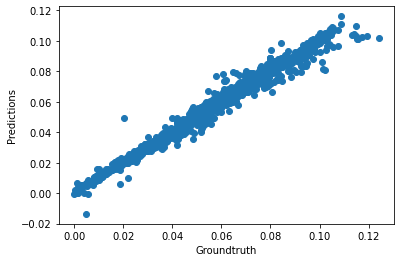

In [16]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Groundtruth")
plt.ylabel("Predictions")

In [17]:
#%store model_fl_com_x

In [18]:
#for idx, prediction in enumerate(predictions):
#    print(f'Groundtruth: {Y_test[idx]}. Predicted: {prediction}')

In [19]:
# Save model
#joblib.dump(model_fl_com_x, "/home/itaouil/workspace/aliengo_ws/src/aliengo_navigation/models/protocol3/model_fl_com_x.sav")

## Predict CoM foot -> y

### Linear Regression

In [20]:
# Input
X = np.hstack((X_motion_CoM_FL_RR[:, :3], # motion command
               X_motion_CoM_FL_RR[:, -3:], # Current motion command
               X_motion_CoM_FL_RR[:, 9:11], # FL (x,y) position
               X_motion_CoM_FL_RR[:, 12:14], # FR (x,y) position
               X_motion_CoM_FL_RR[:, 15:17], # RL (x,y) position
               X_motion_CoM_FL_RR[:, 18:20])) 

# Labels
Y = np.array([Y_motion_CoM_FL_RR[:, 1]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, shuffle=True, random_state=100)

# Create the model
model_fl_com_y = LinearRegression()

# Fit the model
model_fl_com_y.fit(X_train, Y_train)

# Predict
predictions = model_fl_com_y.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  0.7113223845956727
RMSE:  0.004524504793919388
The lowest error is:  6.3766481509103246e-06
The highest error is:  0.044034783252152626
The avg. error is:  0.0031025199754058435


In [21]:
model_fl_com_y.coef_

array([[ 1.02121408e-02,  1.45716772e-16, -8.32667268e-17,
         4.19440441e-02,  0.00000000e+00,  6.93889390e-17,
         1.17048624e-01,  2.85962026e-01, -4.68360035e-01,
        -4.79152356e-02,  2.04777449e-01, -2.37750208e-01,
         8.20935478e-02,  6.44944076e-02]])

In [22]:
model_fl_com_y.intercept_

array([0.15039799])

Text(0, 0.5, 'Predictions')

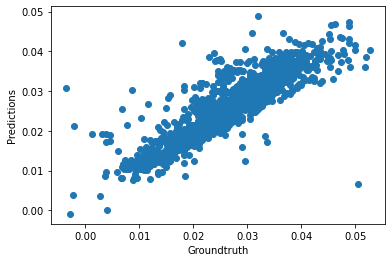

In [23]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Groundtruth")
plt.ylabel("Predictions")

In [24]:
#%store model_fl_com_y

In [25]:
#for idx, prediction in enumerate(predictions):
#    print(f'Groundtruth: {Y_test[idx]}. Predicted: {prediction}')

In [26]:
# Save model
#joblib.dump(model_fl_com_y, "/home/itaouil/workspace/aliengo_ws/src/aliengo_navigation/models/protocol3/model_fl_com_y.sav")